####Pick 

In [5]:
# This script creates a dataset that represents the distance that the average
# tweet is from its neighbors in vector space. It also notes whether or not
# each tweet is spam, to create a visualization that shows graphically how I
# picked a distance cutoff point.
import math
import re
import string
from pymongo import MongoClient
import time
from sklearn.neighbors import LSHForest
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.feature_extraction import text

class singleTweet:
    """Allows basic operations to be performed on a single tweet. Must import
    regex for this to work properly.
    
                ------------------------------------------------
    Methods:
    
    .tweet               Returns the tweet as a string.
    .strip_non_ascii()   Strips non-ascii characters from the tweet string.
    .strip_punctuation() Strips punctuation. If strip_hashtags is set to False,
                         then it does NOT strip hashtags. Otherwise, strips them.
    .utf8()              Converts the tweet to utf-8 if possible.
    .urls                The regex used to match urls. Modify as needed.
    .strip_links()       Strips links by using regex to sub out any words that
                         contain 'http' or any of a number of suffixes contained
                         in self.urls
    .lowercase()         Converts tweet to all lowercase.
    .strip_newlines()    Strips newline characters from the tweet.
    .strip_and_lower()   Performs all stripping functions (including stripping 
                         non-ascii chars) and lowercases the tweet. Does NOT 
                         convert it to utf-8.
    """
    
    def __init__(self, tweet):
        self.tweet = tweet
        pass

    def strip_non_ascii(self):
        """Replaces all non-ascii characters in the tweet with a space. Returns
        tweet."""

        self.tweet = ''.join([i if ord(i) < 128 else ' ' for i in self.tweet])

    punctuation = re.compile('[%s]' % re.escape(string.punctuation))
    punctuation_sans_hashtags = re.compile('[%s]' % 
                                           re.escape(string.punctuation.replace('#', '')))

    def strip_punctuation(self, strip_hashtags = True):
        """Removes punctuation. If strip_hashtags = True, then also removes 
        hashtags. Returns tweet."""

        if strip_hashtags:
            self.tweet = self.punctuation.sub('', self.tweet)
        else:
            self.tweet = self.punctuation_sans_hashtags.sub('', self.tweet)

    def utf8(self):
        """Converts tweet to utf-8 encoding, if possible."""

        self.tweet = unicode(self.tweet, "utf-8")

    urls = re.compile(r"""(http\S+ ?)|(\S+\.com?\S+ ?)|(\S+\.ly?\S+ ?)|(\S+\.net?\S+ ?)|(\S+\.gov?\S+ ?)|(\S+\.edu?\S+ ?)|(\S+\.org?\S+ ?)""")

    def strip_links(self):
        """Uses regex to remove anything that looks like a link in the tweet.
        Identifies text that looks like a tweet using URL suffixes."""

        self.tweet = self.urls.sub('', self.tweet)

    def lowercase(self):
        """Converts tweet to all lowercase characters."""

        self.tweet = self.tweet.lower()

    def strip_newlines(self):
        """Strips newline characters from tweet."""

        self.tweet = self.tweet.replace('\n', '')

    def strip_and_lower(self):
        """Performs all stripping functions (including stripping non-ascii chars)
        and lowercases the tweet. Does NOT convert it to utf-8."""

        self.strip_non_ascii()
        self.strip_links()
        self.lowercase()
        self.strip_punctuation()
        self.strip_newlines()

common_twitter_handles = ['katyperry', 'justinbieber', 'barackobama', \
        'taylorswift13', 'youtube', 'ladygaga', 'rihanna', 'jtimberlake', 'theellenshow', \
        'britneyspears', 'instagram', 'twitter', 'cristiano', 'jlo', 'kimkardashian', \
        'shakira', 'arianagrande', 'selenagomez', 'ddlovato', 'oprah', 'cnnbrk', 'pink', \
        'jimmyfallon', 'harrystyles', 'onedirection', 'liltunechi', 'kaka', 'drake', \
        'officialadele', 'niallofficial', 'aliciakeys', 'billgates', 'brunomars', \
        'pitbull', 'realliampayne', 'kingjames', 'wizkhalifa', 'louistomlinson', \
        'mileycyrus', 'eminem', 'nickiminaj', 'avrillavigne', 'espn', 'neymarjr', \
        'emwatson', 'kevinhart4real', 'cnn', 'davidguetta', 'danieltosh', 'aplusk', \
        'sportscenter', 'nytimes', 'conanobrien', 'actuallynph', 'mariahcarey', 'realmadrid', \
        'xtina', 'zaynmalik', 'srbachchan', 'coldplay', 'fcbarcelona', 'kourtneykardash', \
        'twitteres', 'nba', 'chrisbrown', 'vine', 'beyonce', 'jimcarrey', 'bbcbreaking', \
        'khloekardashian', 'facebook', 'edsheeran', 'iamsrk', 'parishilton', 'ryanseacrest', \
        'iamwill', 'ashleytisdale', 'agnezmo', 'narendramodi', 'leodicaprio', 'ivetesangalo', \
        'tyrabanks', 'alejandrosanz', 'ubersoc', 'mtv', 'blakeshelton', 'snoopdogg', \
        'aamirkhan', 'rickymartin', 'simoncowell', 'kanyewest', 'mohamadalarefe', \
        'beingsalmankhan', '10ronaldinho', 'charliesheen', 'google', 'nfl', 'waynerooney', \
        'claudialeitte', 'dalailam']

# Establish mongo info:
client = MongoClient()
db = client.tweets
collect = db.test_collection


####Pick random non-spam tweets and find distances between them:

In [7]:
from random import random
import math

# Pick random NON-SPAM TWEETS and find distances between them:
found = collect.find( { 'spam_rating' : 0 } )

import string
import random
def string_generator(size=6, chars=string.ascii_lowercase + string.digits):
    return ''.join(random.choice(chars) for _ in range(size))

tweets = []
counter = 0
while found.alive == True:
    if len(tweets) % 1000 == 0: print len(tweets)
    tweet = found.next()['text']
    if random.random() < .021:
        t = singleTweet(tweet)
        t.strip_and_lower()
        if len(t.tweet.split()) < 3:
            t.tweet += ' %s' % string_generator()
        tweets.append(t.tweet)

tweets2 = random.sample(tweets, 10000)
vect2 = CountVectorizer(stop_words = common_twitter_handles)
X2 = vect2.fit_transform(tweets2)
tree2 = LSHForest()
tree2.fit(X2)

# Build tree:
neighbors_distance_non_spam = []
nonspam_actual_neighbors = []
counter = 0
for x in X2:
    counter += 1
    if counter % 100 == 0: print counter
    neighbors = tree2.kneighbors(x, n_neighbors = 3)
    neighbors_distance_non_spam.append(np.sum(neighbors[0][0])/2)
    nonspam_actual_neighbors.append([tweets2[n] for n in neighbors[1][0]])
print np.mean(neighbors_distance_non_spam)



100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
0.696273675363


####Pick random SPAM tweets and find distances between them:

In [9]:
# Pick random SPAM TWEETS and find distances between them:
found = collect.find( { 'spam_rating' : 1 } )

import string
import random
def string_generator(size=6, chars=string.ascii_lowercase + string.digits):
    return ''.join(random.choice(chars) for _ in range(size))

tweets = []
counter = 0
while found.alive == True:
    if len(tweets) % 1000 == 0: print len(tweets)
    tweet = found.next()['text']
    if random.random() < .2:
        t = singleTweet(tweet)
        t.strip_and_lower()
        if len(t.tweet.split()) < 3:
            t.tweet += ' %s' % string_generator()
        tweets.append(t.tweet)

tweets2 = random.sample(tweets, 10000)
vect2 = CountVectorizer(stop_words = common_twitter_handles)
X2 = vect2.fit_transform(tweets2)
tree2 = LSHForest()
tree2.fit(X2)

# Build tree:
neighbors_distance_spam_tweets = []
spam_actual_neighbors = []
counter = 0
for x in vect2.transform(tweets2):
    counter += 1
    if counter % 100 == 0: print counter
    neighbors = tree2.kneighbors(x, n_neighbors = 3)
    neighbors_distance_spam_tweets.append(np.sum(neighbors[0][0])/2)
    spam_actual_neighbors.append([tweets2[n] for n in neighbors[1][0]])
print np.mean(neighbors_distance_spam_tweets)


0
0
0
0
0
1000
1000
1000
1000
1000
1000
1000
2000
2000
2000
2000
2000
2000
2000
2000
2000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
3000
4000
4000
4000
4000
4000
5000
5000
5000
5000
5000
5000
5000
6000
7000
7000
8000
8000
8000
8000
8000
9000
9000
9000
9000
9000
9000
9000
9000
9000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
11000
11000
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
0.125316474369


####Print the non-spam tweets, along with their cosine distances, to a file:

In [10]:
with open('non_spam_sample.txt', 'w') as outfile:
    for x in range(len(nonspam_actual_neighbors)):
        outfile.write(str(neighbors_distance_non_spam[x]) + '\n')
        for t in nonspam_actual_neighbors[x]:
            outfile.write(t + '\n')
        outfile.write('\n\n\n')

####Plot just the non-spam tweets:

(array([  3.00000000e+00,   1.40000000e+01,   3.90000000e+01,
          3.03000000e+02,   4.60000000e+02,   1.23600000e+03,
          2.89000000e+03,   3.06100000e+03,   1.31900000e+03,
          6.75000000e+02]),
 array([ -3.33066907e-16,   1.00000000e-01,   2.00000000e-01,
          3.00000000e-01,   4.00000000e-01,   5.00000000e-01,
          6.00000000e-01,   7.00000000e-01,   8.00000000e-01,
          9.00000000e-01,   1.00000000e+00]),
 <a list of 10 Patch objects>)

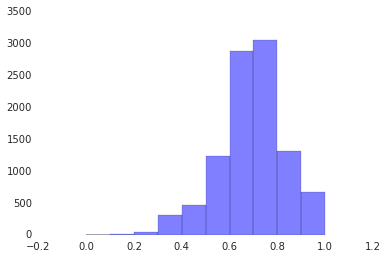

In [20]:
# Plot just the non-spam tweets
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
plt.hist(neighbors_distance_non_spam, alpha = .5, color = "blue")

####Plot the spam and non-spam tweet distance distributions side by side:

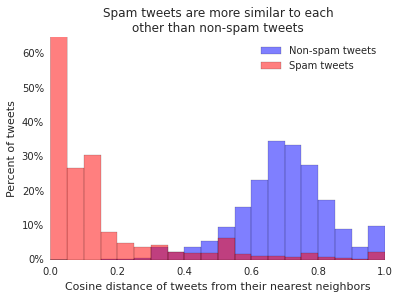

In [93]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style(rc = {'font.family': ['sans-serif'], 'font.sans-serif': ['Helvetica', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif']})

fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(neighbors_distance_non_spam, alpha = .5, color = "blue", label = "Non-spam tweets", normed = True, bins = 20)
plt.hist(neighbors_distance_spam_tweets, alpha = .5, color = "red", label = "Spam tweets", normed = True, bins = 20)

plt.axis((0,1,0,6.5))
ax.set_yticklabels(('0%', '10%', '20%', '30%', '40%', '50%', '60%'))
plt.title("Spam tweets are more similar to each \nother than non-spam tweets")
plt.legend()
plt.xlabel("Cosine distance of tweets from their nearest neighbors")
plt.ylabel("Percent of tweets")
# plt.hist(neighbors_distance_rand_sample, alpha = .5, color = "gray")

from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('multipage.pdf')
pp.savefig()
pp.close()

####Print distances data to files, so the above graph is easy to re-create

In [57]:
# Print all the distances data to files:
with open('cosine_distances_spam.txt', 'w') as outfile:
    for d in neighbors_distance_spam_tweets:
        outfile.write(str(d) + '\n')

with open('cosine_distances_non_spam.txt', 'w') as outfile:
    for d in neighbors_distance_non_spam:
        outfile.write(str(d) + '\n')

####Now plot the distribution of cosine similarities in a random sample of tweets, without considering which ones are spam and which aren't:

In [82]:
# Pick random tweets, regardless of whether or not they're spam, and find distances between them:
found = collect.find( { 'text' : {'$exists' : True } } )

import string
import random
def string_generator(size=6, chars=string.ascii_lowercase + string.digits):
    return ''.join(random.choice(chars) for _ in range(size))

tweets = []
counter = 0
while found.alive == True:
    if len(tweets) == 5001: break
    tweet = found.next()['text']
    if random.random() < .08:
        if len(tweets) % 100 == 0: print len(tweets)
        t = singleTweet(tweet)
        t.strip_and_lower()
        if len(t.tweet.split()) < 3:
            t.tweet += ' %s' % string_generator()
        tweets.append(t.tweet)

print len(tweets)
tweets2 = random.sample(tweets, 5000)
vect2 = CountVectorizer(stop_words = common_twitter_handles)
X2 = vect2.fit_transform(tweets2)
tree2 = LSHForest()
tree2.fit(X2)

# Build tree:
neighbors_distance_rand_tweets = []
rand_actual_neighbors = []
counter = 0
for x in vect2.transform(tweets2):
    counter += 1
    if counter % 100 == 0: print counter
    neighbors = tree2.kneighbors(x, n_neighbors = 3)
    neighbors_distance_rand_tweets.append(np.sum(neighbors[0][0])/2)
    rand_actual_neighbors.append([tweets2[n] for n in neighbors[1][0]])
print np.mean(neighbors_distance_rand_tweets)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5001
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
0.645131365627


####Print random distances to a file and graph it:

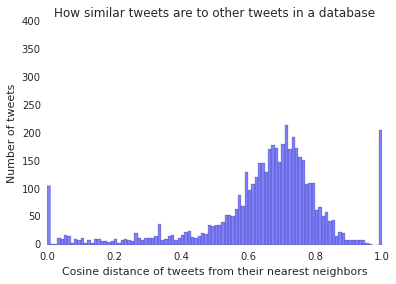

In [83]:
# Print all the distances data to files:
with open('cosine_distances_random_tweets.txt', 'w') as outfile:
    for d in neighbors_distance_rand_tweets:
        outfile.write(str(d) + '\n')

# Plot just the non-spam tweets
# fig = plt.figure()
# ax = fig.add_subplot(111)
plt.hist(neighbors_distance_rand_tweets, alpha = .5, color = "blue", bins = 100)

plt.axis((0,1,0,400))
# ax.set_yticklabels(('0%', '10%', '20%', '30%', '40%', '50%', '60%'))
plt.title("How similar tweets are to other tweets in a database")
plt.xlabel("Cosine distance of tweets from their nearest neighbors")
plt.ylabel("Number of tweets")
plt.savefig('cosine distance of tweets from their nearest neighbors.pdf', format = 'pdf')